In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#install packages

In [ ]:
pip install pyAudioAnalysis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.3 MB 9.1 MB/s 
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.14-py3-none-any.whl size=41264389 sha256=98a547ff31a248dd673e3e6341ca77dd5e97466f4db9dfb971be4555f8866a1a
  Stored in directory: /root/.cache/pip/wheels/85/b4/52/c6a5bdc8517a9bc4cc95aca9839f118d25139aee7881a8d210
Successfully built pyAudioAnalysis


In [ ]:
pip install eyed3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 245 kB 5.2 MB/s 
     |████████████████████████████████| 242 kB 58.2 MB/s 
  Attempting uninstall: coverage
    Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires coverage==3.7.1, but you have coverage 5.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
coveralls 0.5 requires coverage<3.999,>=3.6, but you have coverage 5.5 which is incompatible.


In [ ]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 129 kB 5.2 MB/s 


In [ ]:
#### DO NOT IMPLEMENT THIS CELL ####
## to remove the error of incomplete wave chunk- 
# open files with librosa and write them back with scipy.io.wavfile.write

import os
import sys
import glob
import numpy as np
import librosa
from scipy.io import wavfile

def main(pathAudio):
	# for dirs in os.listdir(pathAudio):
	auds = glob.glob(os.path.join(pathAudio))
	for aud in auds:
		wavs = glob.glob(os.path.join(pathAudio, aud + '/*.wav'))
		for wav in wavs:
			print(wav)
			y, sr = librosa.load(wav, sr = 16000, mono=True)
			y = y * 32767 / max(0.01, np.max(np.abs(y)))
			wavfile.write(wav, sr, y.astype(np.int16))

if __name__ == '__main__':
	main('/content/drive/My Drive/audio_data/audio')

# segmentation

In [ ]:
import os
from pyAudioAnalysis import audioBasicIO as aIO
from pyAudioAnalysis import audioSegmentation as aS
import scipy.io.wavfile as wavfile
import wave

In [ ]:
"""
A script that iterates through the extracted wav files and uses
pyAudioAnalysis' silence extraction module to make a wav file containing the
segmented audio (when the participant is speaking -- silence and virtual
interviewer speech removed)
"""

In [ ]:
def concatenate_segments(participant_dir, partic_id, remove_segment=True):
    """
    A function that concatenates all the wave files in a participants
    directory in to single wav file (with silence and other speakers removed)
    and writes in to the participant's directory, then removes the individual
    segments (when remove_segment=True).
    """
    infiles = os.listdir(participant_dir)  # list of wav files in directory
    outfile = '{}_no_silence.wav'.format(partic_id)

    data = []
    for infile in infiles:
        print("infile:", infile)
        w = wave.open(infile, 'rb')
        data.append([w.getparams(), w.readframes(w.getnframes())])
        w.close()
        if remove_segment:
            os.remove(infile)

    output = wave.open(outfile, 'wb')
    # details of the files must be the same (channel, frame rates, etc.)
    output.setparams(data[0][0])

    # write each segment to output
    for idx in range(len(data)):
        output.writeframes(data[idx][1])
    output.close()


In [ ]:
def remove_silence(filename, out_dir, smoothing=1.0, weight=0.3, plot=False):
    """
    A function that implements pyAudioAnalysis' silence extraction module
    and creates wav files of the participant specific portions of audio. The
    smoothing and weight parameters were tuned for the AVEC 2016 dataset.
    Parameters
    ----------
    filename : filepath
        path to the input wav file
    out_dir : filepath
        path to the desired directory (where a participant folder will
        be created containing a 'PXXX_no_silence.wav' file)
    smoothing : float
        tunable parameter to compensate for sparseness of recordings
    weight : float
        probability threshold for silence removal used in SVM
    plot : bool
        plots SVM probabilities of silence (used in tuning)
    Returns
    -------
    A folder for each participant containing a single wav file
    (named 'PXXX_no_silence.wav') with the vast majority of silence
    and virtual interviewer speech removed. Feature extraction is
    performed on these segmented wav files.
    """
    partic_id = 'P' + filename.split('/')[-1].split('_')[0]  # PXXX
    if is_segmentable(partic_id):
        # create participant directory for segmented wav files
        participant_dir = os.path.join(out_dir, partic_id)
        if not os.path.exists(participant_dir):
            os.makedirs(participant_dir)

        os.chdir(participant_dir)

        [Fs, x] = aIO.read_audio_file(filename)
        segments = aS.silence_removal(x, Fs, 0.020, 0.020,
                                     smooth_window=smoothing,
                                     weight=weight,
                                     plot=plot)

        for s in segments:
            seg_name = "{:s}_{:.2f}-{:.2f}.wav".format(partic_id, s[0], s[1])
            wavfile.write(seg_name, Fs, x[int(Fs * s[0]):int(Fs * s[1])])

        # concatenate segmented wave files within participant directory
        concatenate_segments(participant_dir, partic_id)


In [ ]:
def is_segmentable(partic_id):
    """
    A function that returns True if the participant's interview clip is not
    in the manually identified set of troubled clips. The clips below were
    not segmentable do to excessive static, proximity to the virtual
    interviewer, volume levels, etc.
    """
    troubled = set(['P300', 'P305', 'P306', 'P308', 'P315', 'P316', 'P343',
                    'P354', 'P362', 'P375', 'P378', 'P381', 'P382', 'P385',
                    'P387', 'P388', 'P390', 'P392', 'P393', 'P395', 'P408',
                    'P413', 'P421', 'P438', 'P473', 'P476', 'P479', 'P490',
                    'P492'])
    return partic_id not in troubled

In [ ]:
if __name__ == '__main__':
    # directory containing raw wav files
    dir_name = '/content/drive/My Drive/audio_data/audio'

    # directory where a participant folder will be created containing their
    # segmented wav file
    out_dir = '/content/drive/My Drive/audio_data/interim'

    # iterate through wav files in dir_name and create a segmented wav_file
    for file in os.listdir(dir_name):
        if file.endswith('.wav'):
            filename = os.path.join(dir_name, file)
            remove_silence(filename, out_dir)

# Augmentation

In [ ]:
import numpy as np
import pandas as pd

import librosa
import os
import csv

In [ ]:
## required for adding noise
# FUNCTION TO ADD WHITE NOISE
def noise(x):
    noise_amp = 0.05*np.random.uniform()*np.amax(x)   
    x = x.astype('float64') + noise_amp * np.random.normal(size=x.shape[0])
    return x

In [ ]:
# FUNCTION TO INCREASE SPEED AND PITCH 
def speedNpitch(x):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change 
    tmp = np.interp(np.arange(0,len(x),speed_fac),np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x *= 0
    x[0:minlen] = tmp[0:minlen]
    return x

In [ ]:
# FUNCTION TO STRETCH THE SOUND
def stretch(x, rate=0.8):
    data = librosa.effects.time_stretch(x, rate)
    return data

In [ ]:
dir_name= '/content/drive/My Drive/audio_data/interim'

## To add noise

In [ ]:
# generating a dataset
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [ ]:
file = open('/content/drive/My Drive/audio_data/noise_data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

In [ ]:
for subdir, dirs, files in os.walk(dir_name):
        for file in files:
            if file.endswith('.wav'):
              wav_file = os.path.join(subdir, file)
              png_name = subdir + '/' + file[:-4] + '.png'
              print('Processing ' + file + '...')

              x , sr = librosa.load(wav_file)

              aug = noise(x)

              chroma_stft = librosa.feature.chroma_stft(y=aug, sr=sr)
              # chroma_stft = librosa.stft(x)
              rmse = librosa.feature.rms(aug)
              spec_bw = librosa.feature.spectral_bandwidth(y=aug, sr=sr)
              #display Spectrogram
              X = librosa.stft(aug)
              Xdb = librosa.amplitude_to_db(abs(X))

              zero_crossings = librosa.feature.zero_crossing_rate(aug)

              spectral_centroids = librosa.feature.spectral_centroid(aug, sr=sr)

              spectral_rolloff = librosa.feature.spectral_rolloff(aug, sr=sr)
              mfccs = librosa.feature.mfcc(aug, sr=sr)
              print(mfccs.shape)

              to_append = f'{wav_file} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spectral_centroids)} {np.mean(spec_bw)} {np.mean(spectral_rolloff)} {np.mean(zero_crossings)}'

              for e in mfccs:
                  to_append += f' {np.mean(e)}'
              to_append += f' {file}'
              file = open('/content/drive/My Drive/audio_data/noise_data.csv', 'a', newline='')
              with file:
                  writer = csv.writer(file)
                  writer.writerow(to_append.split())

Processing P301_no_silence.wav...
(20, 40907)
Processing P365_no_silence.wav...
(20, 75003)
Processing P325_no_silence.wav...
(20, 46369)
Processing P336_no_silence.wav...
(20, 40915)
Processing P332_no_silence.wav...
(20, 36064)
Processing P340_no_silence.wav...
(20, 18097)
Processing P326_no_silence.wav...
(20, 25834)
Processing P334_no_silence.wav...
(20, 44154)
Processing P383_no_silence.wav...
(20, 80074)
Processing P327_no_silence.wav...
(20, 27388)
Processing P319_no_silence.wav...
(20, 24657)
Processing P324_no_silence.wav...
(20, 30839)
Processing P369_no_silence.wav...
(20, 66210)
Processing P328_no_silence.wav...
(20, 52921)
Processing P320_no_silence.wav...
(20, 29118)
Processing P318_no_silence.wav...
(20, 23757)
Processing P333_no_silence.wav...
(20, 41412)
Processing P409_no_silence.wav...
(20, 60417)
Processing P312_no_silence.wav...
(20, 53303)
Processing P377_no_silence.wav...
(20, 90292)
Processing P307_no_silence.wav...
(20, 66839)
Processing P311_no_silence.wav...


## To increase pitch and speed

In [ ]:
# generating a dataset
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [ ]:
file = open('/content/drive/My Drive/audio_data/speedp_data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

In [ ]:
for subdir, dirs, files in os.walk(dir_name):
        for file in files:
            if file.endswith('.wav'):
              wav_file = os.path.join(subdir, file)
              png_name = subdir + '/' + file[:-4] + '.png'
              print('Processing ' + file + '...')

              x , sr = librosa.load(wav_file)

              aug = speedNpitch(x)

              chroma_stft = librosa.feature.chroma_stft(y=aug, sr=sr)
              # chroma_stft = librosa.stft(x)
              rmse = librosa.feature.rms(aug)
              spec_bw = librosa.feature.spectral_bandwidth(y=aug, sr=sr)
              #display Spectrogram
              X = librosa.stft(aug)
              Xdb = librosa.amplitude_to_db(abs(X))

              zero_crossings = librosa.feature.zero_crossing_rate(aug)

              spectral_centroids = librosa.feature.spectral_centroid(aug, sr=sr)

              spectral_rolloff = librosa.feature.spectral_rolloff(aug, sr=sr)
              mfccs = librosa.feature.mfcc(aug, sr=sr)
              print(mfccs.shape)

              to_append = f'{wav_file} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spectral_centroids)} {np.mean(spec_bw)} {np.mean(spectral_rolloff)} {np.mean(zero_crossings)}'

              for e in mfccs:
                  to_append += f' {np.mean(e)}'
              to_append += f' {file}'
              file = open('/content/drive/My Drive/audio_data/speedp_data.csv', 'a', newline='')
              with file:
                  writer = csv.writer(file)
                  writer.writerow(to_append.split())

Processing P301_no_silence.wav...
(20, 40907)
Processing P365_no_silence.wav...
(20, 75003)
Processing P325_no_silence.wav...
(20, 46369)
Processing P336_no_silence.wav...
(20, 40915)
Processing P332_no_silence.wav...
(20, 36064)
Processing P340_no_silence.wav...
(20, 18097)
Processing P326_no_silence.wav...
(20, 25834)
Processing P334_no_silence.wav...
(20, 44154)
Processing P383_no_silence.wav...
(20, 80074)
Processing P327_no_silence.wav...
(20, 27388)
Processing P319_no_silence.wav...
(20, 24657)
Processing P324_no_silence.wav...
(20, 30839)
Processing P369_no_silence.wav...
(20, 66210)
Processing P328_no_silence.wav...
(20, 52921)
Processing P320_no_silence.wav...
(20, 29118)
Processing P318_no_silence.wav...
(20, 23757)
Processing P333_no_silence.wav...
(20, 41412)
Processing P409_no_silence.wav...
(20, 60417)
Processing P312_no_silence.wav...
(20, 53303)
Processing P377_no_silence.wav...
(20, 90292)
Processing P307_no_silence.wav...
(20, 66839)
Processing P311_no_silence.wav...


## To add stretch

In [ ]:
# generating a dataset
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [ ]:
file = open('/content/drive/My Drive/audio_data/stretch_data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

In [ ]:
for subdir, dirs, files in os.walk(dir_name):
        for file in files:
            if file.endswith('.wav'):
              wav_file = os.path.join(subdir, file)
              png_name = subdir + '/' + file[:-4] + '.png'
              print('Processing ' + file + '...')

              x , sr = librosa.load(wav_file)

              aug = stretch(x)

              chroma_stft = librosa.feature.chroma_stft(y=aug, sr=sr)
              # chroma_stft = librosa.stft(x)
              rmse = librosa.feature.rms(aug)
              spec_bw = librosa.feature.spectral_bandwidth(y=aug, sr=sr)
              #display Spectrogram
              X = librosa.stft(aug)
              Xdb = librosa.amplitude_to_db(abs(X))

              zero_crossings = librosa.feature.zero_crossing_rate(aug)

              spectral_centroids = librosa.feature.spectral_centroid(aug, sr=sr)

              spectral_rolloff = librosa.feature.spectral_rolloff(aug, sr=sr)
              mfccs = librosa.feature.mfcc(aug, sr=sr)
              print(mfccs.shape)

              to_append = f'{wav_file} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spectral_centroids)} {np.mean(spec_bw)} {np.mean(spectral_rolloff)} {np.mean(zero_crossings)}'

              for e in mfccs:
                  to_append += f' {np.mean(e)}'
              to_append += f' {file}'
              file = open('/content/drive/My Drive/audio_data/stretch_data.csv', 'a', newline='')
              with file:
                  writer = csv.writer(file)
                  writer.writerow(to_append.split())

## Combining all data

In [ ]:
df = pd.read_csv('/content/drive/My Drive/audio_data/data.csv', header=None)

In [ ]:
noise_df = pd.read_csv('/content/drive/My Drive/audio_data/noise_data.csv', header=None)
speedp_df = pd.read_csv('/content/drive/My Drive/audio_data/speedp_data.csv', header=None)
stretch_df = pd.read_csv('/content/drive/My Drive/audio_data/stretch_data.csv', header=None)

In [ ]:
#### concatenate files
combined_df = pd.concat([df, noise_df, speedp_df,stretch_df], ignore_index=True)


In [ ]:
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,/content/drive/My,Drive/audio_data/interim/P365/P365_no_silence.wav,0.569320,0.017554,1179.037573,1526.276326,2431.840489,0.047237,-378.723999,89.888130,...,-0.833143,2.360463,3.653419,2.640903,2.180515,-0.018859,2.898318,0.768065,P365_no_silence.wav,1
1,/content/drive/My,Drive/audio_data/interim/P325/P325_no_silence.wav,0.358157,0.027760,1358.624741,1415.536135,2604.327427,0.065088,-358.913391,100.120476,...,-0.269885,-1.964366,3.397129,-3.236047,-1.490361,1.393715,-2.004146,-2.106658,P325_no_silence.wav,1
2,/content/drive/My,Drive/audio_data/interim/P336/P336_no_silence.wav,0.440538,0.027978,1197.019446,1392.292686,2500.084620,0.049712,-379.248291,104.145782,...,0.443118,2.786901,0.584616,1.343224,0.827890,-0.831182,0.379470,0.331436,P336_no_silence.wav,0
3,/content/drive/My,Drive/audio_data/interim/P332/P332_no_silence.wav,0.463018,0.013304,1498.399575,1611.700862,3021.572803,0.066246,-408.170197,76.551636,...,-0.163474,2.424940,2.928302,-2.229471,-0.469260,1.866178,-0.473763,-0.938451,P332_no_silence.wav,1
4,/content/drive/My,Drive/audio_data/interim/P340/P340_no_silence.wav,0.461996,0.028187,1304.979257,1494.103505,2674.776216,0.054946,-353.486176,112.376045,...,6.677998,-1.790910,2.357386,4.616292,-0.267873,-0.669441,1.354952,0.971203,P340_no_silence.wav,0


In [ ]:
combined_df.shape

(640, 30)

In [ ]:
df = combined_df

In [ ]:
df.to_csv('/content/drive/My Drive/audio_data/combined_df.csv')

In [ ]:
df.shape

(640, 30)

# MFCC

In [ ]:
import librosa
from matplotlib import pyplot as plt
import librosa.display

import csv
import os
import numpy as np


## MFCC for single audio file

In [ ]:
audio_path = '/content/drive/My Drive/audio_data/interim/P301/P301_no_silence.wav'

In [ ]:
x , sr = librosa.load(audio_path)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


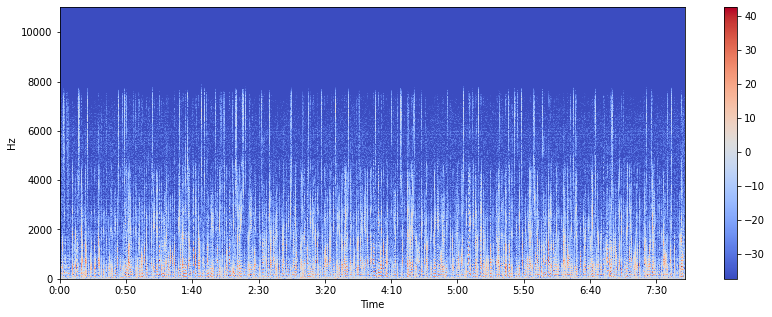

In [ ]:
#display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

In [ ]:
#feature extraction
##zero crossing rate
x, sr = librosa.load(audio_path)
#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

TypeError: ignored

<Figure size 1008x360 with 0 Axes>

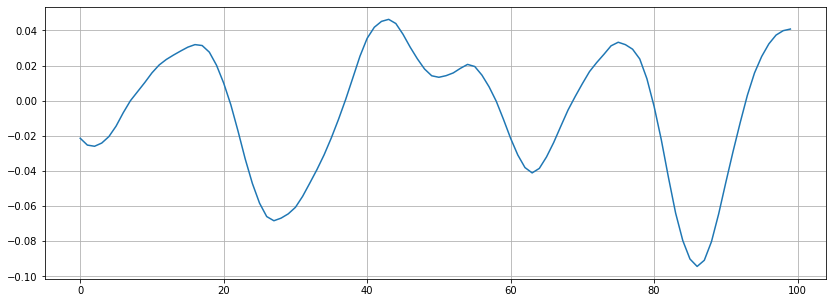

In [ ]:
# zooming in
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

In [ ]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

7


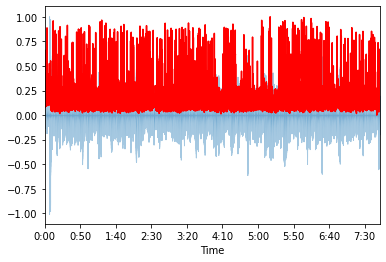

In [ ]:
#spectral centroid
#spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

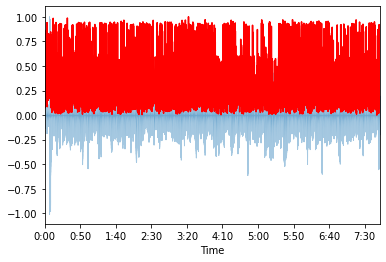

In [ ]:
# spectral rolloff
spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

(20, 20293)


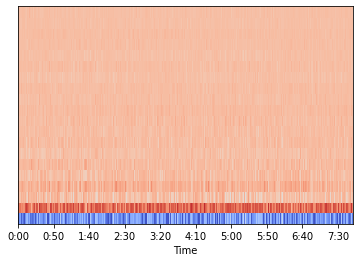

In [ ]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

## MFCC for all data

In [ ]:
dir_name= '/content/drive/My Drive/audio_data/interim'

In [ ]:
# generating a dataset
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [ ]:
file = open('/content/drive/My Drive/audio_data/data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

In [ ]:
for subdir, dirs, files in os.walk(dir_name):
        for file in files:
            if file.endswith('.wav'):
              wav_file = os.path.join(subdir, file)
              png_name = subdir + '/' + file[:-4] + '.png'
              print('Processing ' + file + '...')
#sr=sampling rate

              #load the audio file
              x , sr = librosa.load(wav_file)

              chroma_stft = librosa.feature.chroma_stft(y=x, sr=sr)

              #indicates loudness(root mean square energy)
              rmse = librosa.feature.rms(x)

              spec_bw = librosa.feature.spectral_bandwidth(y=x, sr=sr)
           
           
              X = librosa.stft(x)
              #convert and amplitude spectrogram into decibel scale(to indicate sound)
              Xdb = librosa.amplitude_to_db(abs(X))

              #number of times a signal croses the horizontal axis
              zero_crossings = librosa.feature.zero_crossing_rate(x)

              #Frequency band where most of the energy is concentrated
              spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)

              spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr)
              
              mfccs = librosa.feature.mfcc(x, sr=sr)
              print(mfccs.shape)
             

             #append all features together in one file
              to_append = f'{wav_file} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spectral_centroids)} {np.mean(spec_bw)} {np.mean(spectral_rolloff)} {np.mean(zero_crossings)}'

              for e in mfccs:
                  to_append += f' {np.mean(e)}'
              to_append += f' {file}'
              file = open('/content/drive/My Drive/audio_data/data.csv', 'a', newline='')
              with file:
                  writer = csv.writer(file)
                  writer.writerow(to_append.split())

Processing P365_no_silence.wav...
(20, 36988)
Processing P325_no_silence.wav...
(20, 23195)
Processing P336_no_silence.wav...
(20, 20308)
Processing P332_no_silence.wav...
(20, 18074)
Processing P340_no_silence.wav...
(20, 9001)
Processing P326_no_silence.wav...
(20, 13207)
Processing P334_no_silence.wav...
(20, 22033)
Processing P383_no_silence.wav...
(20, 39964)
Processing P327_no_silence.wav...
(20, 13516)
Processing P319_no_silence.wav...
(20, 12355)
Processing P324_no_silence.wav...
(20, 15593)
Processing P369_no_silence.wav...
(20, 33104)
Processing P328_no_silence.wav...
(20, 26429)
Processing P320_no_silence.wav...
(20, 14550)
Processing P318_no_silence.wav...
(20, 11848)
Processing P333_no_silence.wav...
(20, 20720)
Processing P409_no_silence.wav...
(20, 30217)
Processing P312_no_silence.wav...
(20, 26790)
Processing P377_no_silence.wav...
(20, 45108)
Processing P307_no_silence.wav...
(20, 33406)
Processing P311_no_silence.wav...
(20, 16572)
Processing P337_no_silence.wav...
(

# Models

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
################ DONT EXECUTE FOLLOWING CELLS #################################
################ IMPLEMENT FROM "START HERE" COMMENT ##########################

In [ ]:
df = pd.read_csv('/content/drive/My Drive/audio_data/combined_df.csv', header=None)

In [ ]:
df.head()

,2,3,4,5,6,7,8,9,10,11,...,19,20,21,22,23,24,25,26,27,29
0,0.569320,0.017554,1179.037573,1526.276326,2431.840489,0.047237,-378.723999,89.888130,34.436951,23.434534,...,3.854689,-0.833143,2.360463,3.653419,2.640903,2.180515,-0.018859,2.898318,0.768065,1
1,0.358157,0.027760,1358.624741,1415.536135,2604.327427,0.065088,-358.913391,100.120476,7.161822,15.062524,...,-3.080664,-0.269885,-1.964366,3.397129,-3.236047,-1.490361,1.393715,-2.004146,-2.106658,1
2,0.440538,0.027978,1197.019446,1392.292686,2500.084620,0.049712,-379.248291,104.145782,13.680271,29.738724,...,-2.571175,0.443118,2.786901,0.584616,1.343224,0.827890,-0.831182,0.379470,0.331436,0
3,0.463018,0.013304,1498.399575,1611.700862,3021.572803,0.066246,-408.170197,76.551636,10.367766,16.630489,...,-0.760586,-0.163474,2.424940,2.928302,-2.229471,-0.469260,1.866178,-0.473763,-0.938451,1
4,0.461996,0.028187,1304.979257,1494.103505,2674.776216,0.054946,-353.486176,112.376045,10.709586,24.575321,...,2.108073,6.677998,-1.790910,2.357386,4.616292,-0.267873,-0.669441,1.354952,0.971203,0


In [ ]:
# df.drop(df.columns[[0,1,28]], inplace=True, axis=1)
# df.head()

In [ ]:
df.shape

(640, 27)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2       640 non-null    float64
 1   3       640 non-null    float64
 2   4       640 non-null    float64
 3   5       640 non-null    float64
 4   6       640 non-null    float64
 5   7       640 non-null    float64
 6   8       640 non-null    float64
 7   9       640 non-null    float64
 8   10      640 non-null    float64
 9   11      640 non-null    float64
 10  12      640 non-null    float64
 11  13      640 non-null    float64
 12  14      640 non-null    float64
 13  15      640 non-null    float64
 14  16      640 non-null    float64
 15  17      640 non-null    float64
 16  18      640 non-null    float64
 17  19      640 non-null    float64
 18  20      640 non-null    float64
 19  21      640 non-null    float64
 20  22      640 non-null    float64
 21  23      640 non-null    float64
 22  24

In [ ]:
df.iloc[:,:-1].head()

,2,3,4,5,6,7,8,9,10,11,...,18,19,20,21,22,23,24,25,26,27
0,0.569320,0.017554,1179.037573,1526.276326,2431.840489,0.047237,-378.723999,89.888130,34.436951,23.434534,...,3.535516,3.854689,-0.833143,2.360463,3.653419,2.640903,2.180515,-0.018859,2.898318,0.768065
1,0.358157,0.027760,1358.624741,1415.536135,2604.327427,0.065088,-358.913391,100.120476,7.161822,15.062524,...,1.107063,-3.080664,-0.269885,-1.964366,3.397129,-3.236047,-1.490361,1.393715,-2.004146,-2.106658
2,0.440538,0.027978,1197.019446,1392.292686,2500.084620,0.049712,-379.248291,104.145782,13.680271,29.738724,...,7.812723,-2.571175,0.443118,2.786901,0.584616,1.343224,0.827890,-0.831182,0.379470,0.331436
3,0.463018,0.013304,1498.399575,1611.700862,3021.572803,0.066246,-408.170197,76.551636,10.367766,16.630489,...,2.336517,-0.760586,-0.163474,2.424940,2.928302,-2.229471,-0.469260,1.866178,-0.473763,-0.938451
4,0.461996,0.028187,1304.979257,1494.103505,2674.776216,0.054946,-353.486176,112.376045,10.709586,24.575321,...,3.695489,2.108073,6.677998,-1.790910,2.357386,4.616292,-0.267873,-0.669441,1.354952,0.971203


In [ ]:
y = df.iloc[:, -1]
y.head()

0    1
1    1
2    0
3    1
4    0
Name: 29, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
print(X_train)

[[-6.41113139e-01  6.39490264e-01 -6.78568656e-01 ... -1.89074930e+00
  -1.77751176e+00  2.17086370e+00]
 [-1.54367598e+00  7.81024766e-01 -9.03912024e-01 ...  2.26483228e-01
  -3.51914418e-01 -1.12104387e-04]
 [-8.86728123e-01 -1.29453987e-01 -9.94904484e-01 ... -2.29044270e+00
   1.82873117e+00 -1.06253078e+00]
 ...
 [-1.15656325e+00 -4.20244381e-02  1.35317762e+00 ...  1.09713318e+00
  -1.76823169e+00 -1.69800910e-01]
 [-4.38262990e-01  1.84421272e+00 -9.26034105e-01 ... -1.90818932e+00
  -2.53762471e+00 -1.55675474e+00]
 [-1.09712073e+00 -5.20688100e-01 -4.06987094e-01 ...  2.09638178e-01
  -5.61189943e-01 -1.67388188e+00]]


In [ ]:
np.save('/content/drive/My Drive/audio_data/xtrain.npy', X_train)
np.save('/content/drive/My Drive/audio_data/xtest.npy', X_test)
np.save('/content/drive/My Drive/audio_data/ytrain.npy', y_train)
np.save('/content/drive/My Drive/audio_data/ytest.npy', y_test)

In [ ]:
###################### START HERE #################################################

In [ ]:
X_train = np.load('/content/drive/My Drive/audio_data/xtrain.npy')
X_test = np.load('/content/drive/My Drive/audio_data/xtest.npy')
y_train = np.load('/content/drive/My Drive/audio_data/ytrain.npy')
y_test = np.load('/content/drive/My Drive/audio_data/ytest.npy')


In [ ]:
# #normalizing
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
X_train.shape

(512, 26)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#Keras
import keras
from keras import models
from keras import layers

from sklearn.metrics import classification_report

In [ ]:
# models
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from sklearn.model_selection import cross_val_score

In [ ]:
# creating a model
model = models.Sequential()
model.add(layers.Dense(128, activation='relu' ))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32)

Epoch 1/100
16/16 [==============================] - 4s 3ms/step - loss: 0.6745 - accuracy: 0.5820
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6137 - accuracy: 0.6797
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5843 - accuracy: 0.6797
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5591 - accuracy: 0.6875
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5398 - accuracy: 0.7109
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5128 - accuracy: 0.7402
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4848 - accuracy: 0.7617
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4600 - accuracy: 0.7793
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4270 - accuracy: 0.8047
Epoch 10/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3982 - accuracy: 0.8301
Epoch 11/

In [ ]:
# calculate accuracy
test_loss, test_acc = model.evaluate(X_test,y_test)
print('test_acc: ',test_acc)




4/4 [==============================] - 0s 3ms/step - loss: 0.9635 - accuracy: 0.8281
test_acc:  0.828125


In [ ]:
# predictions
predictions = model.predict(X_test)
# print(predictions)

In [ ]:
print(classification_report(y_test, predictions.round()))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88        96
           1       0.65      0.69      0.67        32

    accuracy                           0.83       128
   macro avg       0.77      0.78      0.78       128
weighted avg       0.83      0.83      0.83       128



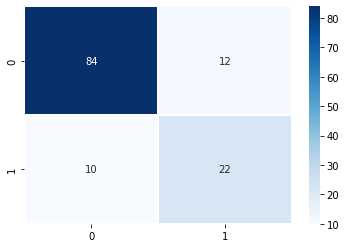

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions.round())
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')

In [ ]:
logmodel = LogisticRegression(max_iter=400)
logmodel.fit(X_train,y_train)

pred_test_log = logmodel.predict(X_test)
pred_log = logmodel.predict(X_train)

print(classification_report(y_test,pred_test_log))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83        96
           1       0.38      0.19      0.25        32

    accuracy                           0.72       128
   macro avg       0.57      0.54      0.54       128
weighted avg       0.67      0.72      0.68       128



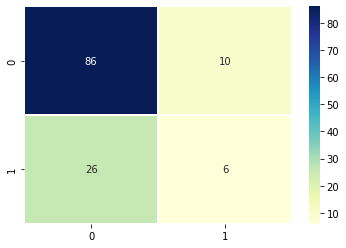

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_test_log)
ax = sns.heatmap(cm, linecolor='white', cmap='YlGnBu', linewidth=1, annot=True, fmt='')

In [ ]:
clf = svm.SVC(kernel='poly')
clf.fit(X_train, y_train) 

pred_svc = clf.predict(X_train)
pred_test_svc = clf.predict(X_test)
# pred_test_svc [0:5]

print (classification_report(y_test, pred_test_svc))

              precision    recall  f1-score   support

           0       0.77      0.99      0.87        96
           1       0.80      0.12      0.22        32

    accuracy                           0.77       128
   macro avg       0.79      0.56      0.54       128
weighted avg       0.78      0.77      0.70       128



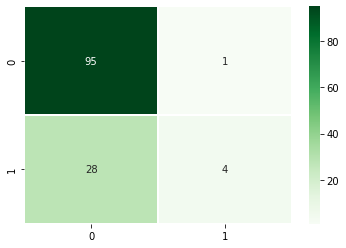

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_test_svc)
ax = sns.heatmap(cm, linecolor='white', cmap='Greens', linewidth=1, annot=True, fmt='')

In [ ]:
k = 45
#Training and Predicting  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
pred_knn = neigh.predict(X_train)
pred_test_knn = neigh.predict(X_test)
pred_test_knn[0:5]

Ks = 50
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    pred_test_knn=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, pred_test_knn)

    
    std_acc[n-1]=np.std(pred_test_knn==y_test)/np.sqrt(pred_test_knn.shape[0])

mean_acc

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.8046875 with k= 2


In [ ]:
neigh = KNeighborsClassifier(n_neighbors = 2).fit(X_train,y_train)
pred_knn = neigh.predict(X_train)
pred_test_knn = neigh.predict(X_test)

In [ ]:
print(classification_report(y_test,pred_test_knn))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88        96
           1       0.77      0.31      0.44        32

    accuracy                           0.80       128
   macro avg       0.79      0.64      0.66       128
weighted avg       0.80      0.80      0.77       128



In [ ]:
import joblib
import pickle
import json

In [ ]:
joblib.dump(neigh, '/content/drive/My Drive/saved_models/audio_knn.pkl')

['/content/drive/My Drive/saved_models/audio_knn.pkl']

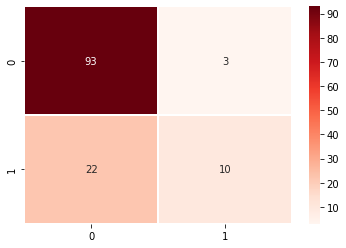

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_test_knn)
ax = sns.heatmap(cm, linecolor='white', cmap='Reds', linewidth=1, annot=True, fmt='')

In [ ]:
DecTree = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
DecTree.fit(X_train,y_train)

pred_decision_tree = DecTree.predict(X_train)
pred_test_decision_tree = DecTree.predict(X_test)

acc_decision_tree = metrics.accuracy_score(y_train, pred_decision_tree) * 100
acc_test_decision_tree = metrics.accuracy_score(y_test, pred_test_decision_tree) * 100

print("Accuracy train : ", acc_decision_tree)
print("Accuracy test : ", acc_test_decision_tree)

print(classification_report(y_test, pred_test_decision_tree))

Accuracy train :  79.296875
Accuracy test :  68.75
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        96
           1       0.30      0.19      0.23        32

    accuracy                           0.69       128
   macro avg       0.53      0.52      0.52       128
weighted avg       0.64      0.69      0.66       128



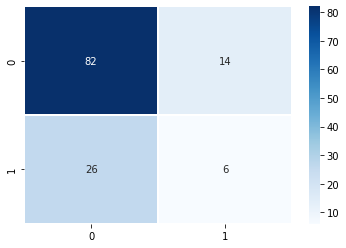

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_test_decision_tree)
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')

In [ ]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    current_score = cross_val_score(clf, X_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score 
 
space_xgb = {
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.005),
            'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.005),
            'gamma': hp.quniform('gamma', 0.5, 1, 0.005),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'tree_method': 'exact',
            'silent': 1,
            'missing': None
        }
 
best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.7090120663650076
{'booster': 'gbtree', 'colsample_bytree': 0.755, 'eta': 0.155, 'eval_metric': 'auc', 'gamma': 0.885, 'learning_rate': 0.0393, 'max_depth': 6, 'min_child_weight': 2.35, 'missing': None, 'n_estimators': 644, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.585, 'tree_method': 'exact'}
0.6972473604826546
{'booster': 'gbtree', 'colsample_bytree': 0.52, 'eta': 0.035, 'eval_metric': 'auc', 'gamma': 0.585, 'learning_rate': 0.0234, 'max_depth': 4, 'min_child_weight': 5.8500000000000005, 'missing': None, 'n_estimators': 290, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.73, 'tree_method': 'exact'}
0.6855203619909502
{'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.48, 'eval_metric': 'auc', 'gamma': 0.505, 'learning_rate': 0.0018000000000000002, 'max_depth': 9, 'min_child_weight': 7.45, 'missing': None, 'n_estimators': 768, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.985, 'tree_method': 'exact'}
0.707051282051282
{

In [ ]:
params = space_eval(space_xgb, best)
params

{'booster': 'gbtree',
 'colsample_bytree': 0.66,
 'eta': 0.485,
 'eval_metric': 'auc',
 'gamma': 0.76,
 'learning_rate': 0.0267,
 'max_depth': 3,
 'min_child_weight': 3.45,
 'missing': None,
 'n_estimators': 137,
 'objective': 'binary:logistic',
 'silent': 1,
 'subsample': 0.52,
 'tree_method': 'exact'}

In [ ]:
XGB_Classifier = XGBClassifier(**params)

XGB_Classifier.fit(X_train, y_train)
acc_XGB_Classifier = round(XGB_Classifier.score(X_train, y_train) * 100, 2)
acc_XGB_Classifier

# pred_XGB = XGB_Classifier.predict(X_train)
# pred_test_xgb = XGB_Classifier.predict(X_test)

# acc_XGB_Classifier = metrics.accuracy_score(y_train, pred_random_forest) * 100
# acc_test_XGB_Classifier = metrics.accuracy_score(y_test, pred_test_random_forest) * 100

81.45

In [ ]:
pred_XGB = XGB_Classifier.predict(X_train)
pred_test_xgb = XGB_Classifier.predict(X_test)

In [ ]:
# print("train acc: ", acc_XGB_Classifier)
# print("test acc: ", acc_test_XGB_Classifier)

In [ ]:
acc_test_XGB_Classifier = round(XGB_Classifier.score(X_test, y_test) * 100, 2)
acc_test_XGB_Classifier

75.0

In [ ]:
print(classification_report(y_test, pred_test_xgb.round()))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85        96
           1       0.50      0.22      0.30        32

    accuracy                           0.75       128
   macro avg       0.64      0.57      0.58       128
weighted avg       0.71      0.75      0.71       128



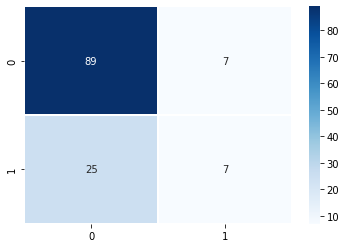

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_test_xgb)
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

def hyperopt_lgb_score(params):
    clf = LGBMClassifier(**params)
    current_score = cross_val_score(clf, X_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score 
 
space_lgb = {
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
            'num_leaves': hp.choice('num_leaves', 2*np.arange(2, 2**11, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
            'objective': 'binary',
            'boosting_type': 'gbdt',
            }
 
best = fmin(fn=hyperopt_lgb_score, space=space_lgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.7207767722473605
{'boosting_type': 'gbdt', 'colsample_bytree': 0.625, 'learning_rate': 0.0337, 'max_depth': 6, 'min_child_weight': 1.8, 'n_estimators': 883, 'num_leaves': 2444, 'objective': 'binary'}
0.7012066365007541
{'boosting_type': 'gbdt', 'colsample_bytree': 0.505, 'learning_rate': 0.0114, 'max_depth': 4, 'min_child_weight': 8.875, 'n_estimators': 345, 'num_leaves': 1690, 'objective': 'binary'}
0.7480392156862745
{'boosting_type': 'gbdt', 'colsample_bytree': 0.93, 'learning_rate': 0.031400000000000004, 'max_depth': 10, 'min_child_weight': 1.3250000000000002, 'n_estimators': 299, 'num_leaves': 2936, 'objective': 'binary'}
0.6972096530920061
{'boosting_type': 'gbdt', 'colsample_bytree': 0.9550000000000001, 'learning_rate': 0.0223, 'max_depth': 3, 'min_child_weight': 6.2, 'n_estimators': 524, 'num_leaves': 2458, 'objective': 'binary'}
0.7070512820512821
{'boosting_type': 'gbdt', 'colsample_bytree': 0.9450000000000001, 'learning_rate': 0.0044, 'max_depth': 7, 'min_child_weight': 1.

In [ ]:
params = space_eval(space_lgb, best)
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.9550000000000001,
 'learning_rate': 0.0223,
 'max_depth': 3,
 'min_child_weight': 6.2,
 'n_estimators': 524,
 'num_leaves': 2458,
 'objective': 'binary'}

In [ ]:
LGB_Classifier = LGBMClassifier(**params)
LGB_Classifier.fit(X_train, y_train)
acc_LGB_Classifier = round(LGB_Classifier.score(X_train, y_train) * 100, 2)
acc_LGB_Classifier

93.55

In [ ]:
acc_test_LGB_Classifier = round(LGB_Classifier.score(X_test, y_test) * 100, 2)
acc_test_LGB_Classifier

75.0

In [ ]:
pred_lgb = LGB_Classifier.predict(X_test)

In [ ]:
print(classification_report(y_test, pred_lgb.round()))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84        96
           1       0.50      0.41      0.45        32

    accuracy                           0.75       128
   macro avg       0.66      0.64      0.64       128
weighted avg       0.74      0.75      0.74       128



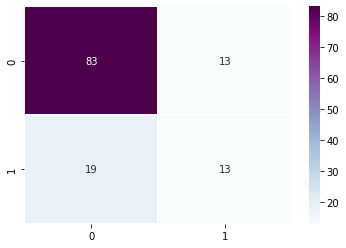

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_lgb)
ax = sns.heatmap(cm, linecolor='white', cmap='BuPu', linewidth=1, annot=True, fmt='')

In [ ]:
bagging_classifier = BaggingClassifier()
bagging_classifier.fit(X_train, y_train)
Y_pred = bagging_classifier.predict(X_test).astype(int)
acc_bagging_classifier = round(bagging_classifier.score(X_train, y_train) * 100, 2)
acc_bagging_classifier

98.83

In [ ]:
acc_test_bagging_classifier = round(bagging_classifier.score(X_test, y_test) * 100, 2)
acc_test_bagging_classifier

77.34

In [ ]:
pred_bg = bagging_classifier.predict(X_test)

In [ ]:
print(classification_report(y_test, pred_bg.round()))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86        96
           1       0.57      0.38      0.45        32

    accuracy                           0.77       128
   macro avg       0.69      0.64      0.65       128
weighted avg       0.75      0.77      0.76       128



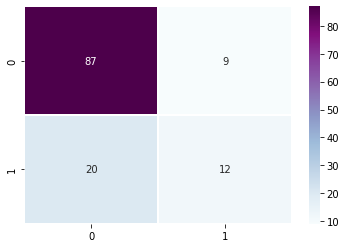

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_bg)
ax = sns.heatmap(cm, linecolor='white', cmap='BuPu', linewidth=1, annot=True, fmt='')

# STOP STOP
## experiments- 84%

In [ ]:
############## STOP ############################################################

In [ ]:
############## STOP ############################################################

In [ ]:
# creating a model
model = models.Sequential()
model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32)

Epoch 1/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6344 - accuracy: 0.6758
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 0.5903 - accuracy: 0.6797
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 0.5651 - accuracy: 0.7031
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 0.5400 - accuracy: 0.6934
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 0.5186 - accuracy: 0.7539
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 0.4871 - accuracy: 0.7539
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 0.4630 - accuracy: 0.8066
Epoch 8/100
16/16 [==============================] - 0s 2ms/step - loss: 0.4473 - accuracy: 0.7715
Epoch 9/100
16/16 [==============================] - 0s 2ms/step - loss: 0.4098 - accuracy: 0.8301
Epoch 10/100
16/16 [==============================] - 0s 2ms/step - loss: 0.3941 - accuracy: 0.8574
Epoch 11/

In [ ]:
test_loss, test_acc = model.evaluate(X_test,y_test)
print('test_acc: ',test_acc)

4/4 [==============================] - 0s 2ms/step - loss: 1.1337 - accuracy: 0.8359
test_acc:  0.8359375


In [ ]:
predictions = model.predict(X_test)
# print(predictions)

In [ ]:
print(classification_report(y_test, predictions.round()))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        96
           1       0.67      0.69      0.68        32

    accuracy                           0.84       128
   macro avg       0.78      0.79      0.78       128
weighted avg       0.84      0.84      0.84       128



In [ ]:
# creating a model
model = models.Sequential()
model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32)

Epoch 1/100
16/16 [==============================] - 0s 2ms/step - loss: 2.6036e-04 - accuracy: 1.0000
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 6.3265e-04 - accuracy: 1.0000
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0601 - accuracy: 0.9824
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6979 - accuracy: 0.8984
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 0.9617 - accuracy: 0.7773
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2807 - accuracy: 0.8809
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1906 - accuracy: 0.9277
Epoch 8/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1396 - accuracy: 0.9453
Epoch 9/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1012 - accuracy: 0.9668
Epoch 10/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0784 - accuracy: 0.9746
E

In [ ]:
test_loss, test_acc = model.evaluate(X_test,y_test)
print('test_acc: ',test_acc)

4/4 [==============================] - 0s 2ms/step - loss: 1.6760 - accuracy: 0.7969
test_acc:  0.796875
